# Obtaining Learning Curves for Sherbrooke and Kyoto Performance

## Sherbrooke PPO Training

In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready

from utils import plot_learning, photon_env_dicts

from rl_algos.ppo_continuous import PPO_make_train
from rl_algos.ppo_clipped_normal import PPO_make_train as PPO_Clipped_make_train

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [3]:
# Defining Sherbrooke Params and RL Params

tau_0 = 0.783
kappa = 14.31
chi = 0.31 * 2. * jnp.pi
kerr = 0.00
n0 = 53.8
res_amp_scaling = 1/0.348
actual_max_photons = n0 * (1. - 2. * jnp.cos(0.5 * chi * tau_0) * jnp.exp(-0.5 * kappa * tau_0) + jnp.exp(-0.5 * kappa * tau_0))
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.05
snr_scale_factor = 1.25
gamma_I = 1/362.9
photon_gamma = 1/4000
init_fid = 1.

time_coeff = 10.0
snr_coeff = 20.0
smoothness_coeff = 10.0
smoothness_baseline_scale = 1.0
gauss_kernel_len = 15
gauss_kernel_std = 2.0
bandwidth = 50.0
freq_relative_cutoff = 0.1
bandwidth_coeff = 0.0
num_t1 = 9.0
photon_weight = 12.0
shot_noise_std = 0.0
standard_fid = 0.99

env_config = {"kappa": kappa,
    "chi": chi,
    "kerr": kerr,
    "time_coeff": time_coeff,
    "snr_coeff": snr_coeff,
    "smoothness_coeff": smoothness_coeff,
    "smoothness_baseline_scale": smoothness_baseline_scale,
    "gauss_kernel_len": gauss_kernel_len,
    "gauss_kernel_std": gauss_kernel_std,
    "bandwidth": bandwidth,
    "freq_relative_cutoff": freq_relative_cutoff,
    "bandwidth_coeff": bandwidth_coeff,
    "n0": n0,
    "tau_0": tau_0,
    "res_amp_scaling": res_amp_scaling,
    "nR": nR,
    "snr_scale_factor": snr_scale_factor,
    "gamma_I": gamma_I,
    "photon_gamma": photon_gamma,
    "num_t1": num_t1,
    "init_fid": init_fid,
    "photon_weight": photon_weight,
    "standard_fid": standard_fid,
    "shot_noise_std": shot_noise_std,
}

num_envs = 256
num_updates = 5000
config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "single_langevin_env",
    "ENV_PARAMS": env_config,
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 53.8
Actual Max Photons: 53.711451977836106


In [4]:
from utils import photon_env_dicts

env = photon_env_dicts()[config["ENV_NAME"]](**config["ENV_PARAMS"])

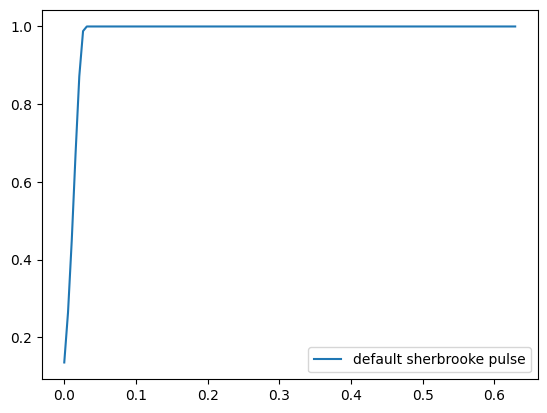

In [5]:
# Default Sherbrooke Action

ts = env.ts_action

gauss_sigma = 0.0142
num_sigma = 2.
total_duration = tau_0

default_pulse = jnp.heaviside((total_duration - num_sigma * gauss_sigma) - ts, 1.) * jnp.heaviside(ts - num_sigma * gauss_sigma, 0.)
default_pulse += jnp.heaviside(num_sigma * gauss_sigma - ts, 1.) * jnp.exp(-(ts - num_sigma * gauss_sigma)**2 / (2 * gauss_sigma**2))
default_pulse += jnp.heaviside(ts - (total_duration - num_sigma * gauss_sigma), 1.) * jnp.exp(-(ts - (total_duration - num_sigma * gauss_sigma))**2 / (2 * gauss_sigma**2))

plt.plot(ts, default_pulse, label='default sherbrooke pulse')
plt.legend()
plt.show()

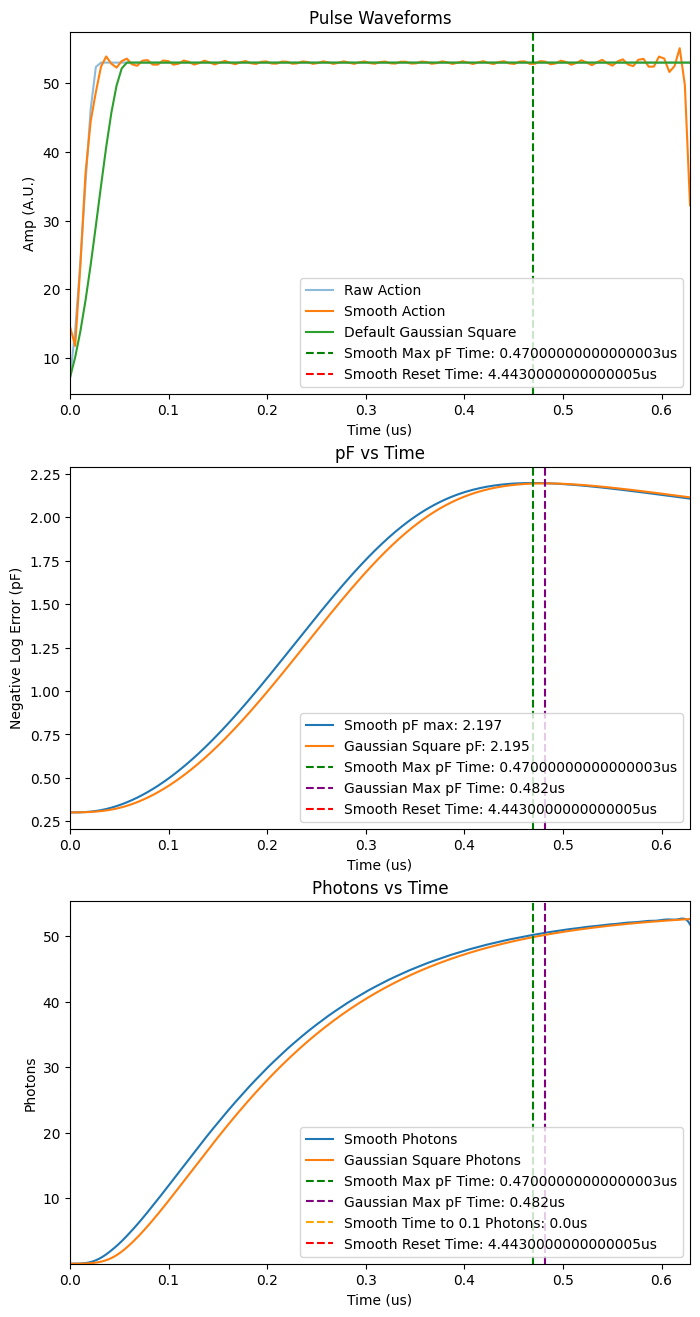

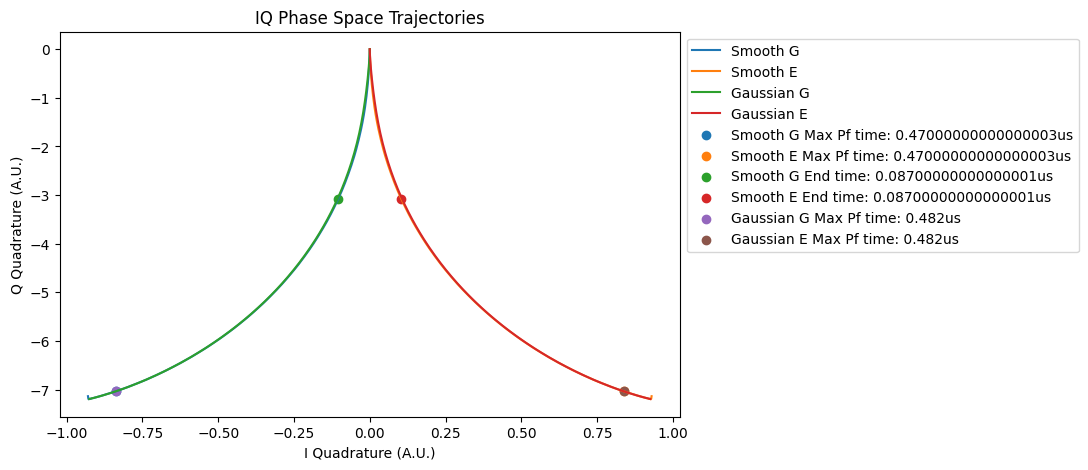

In [6]:
env.rollout_action(_rng, default_pulse)

In [7]:
single_train = jit(PPO_make_train(config), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 6000 Updates
global update: 100
reward: -7.735
max pF: 1.7850000000000001
max photon: 43.523
photon time: 0.8290000000000001
smoothness: 0.006784
bandwidth: 40.881
pulse reset val: 0.258
global update: 200
reward: 1.447
max pF: 1.897
max photon: 46.922000000000004
photon time: 0.8289000000000001
smoothness: 0.005411
bandwidth: 37.586
pulse reset val: 0.222
global update: 300
reward: 9.444
max pF: 1.981
max photon: 48.648
photon time: 0.7404000000000001
smoothness: 0.004495
bandwidth: 34.980000000000004
pulse reset val: 0.199
global update: 400
reward: 14.201
max pF: 2.024
max photon: 49.134
photon time: 0.7368
smoothness: 0.003914
bandwidth: 33.564
pulse reset val: 0.185
global update: 500
reward: 18.853
max pF: 2.051
max photon: 49.475
photon time: 0.6982
smoothness: 0.003183
bandwidth: 30.706
pulse reset val: 0.171
global update: 600
reward: 23.46
max pF: 2.102
max photon: 49.949
photon time: 0.7287
smoothness: 0.0027229999999999997
bandwidth: 27.158
pulse reset val

In [13]:
# Extracting Results

metrics = single_result["metrics"]

rewards = metrics["reward"]
max_pFs = metrics["max pF"]
max_photons = metrics["max photon"]
photon_times = metrics["photon time"]
smoothnesses = metrics["smoothness"]
bandwidths = metrics["bandwidth"]
actions = metrics["action"]
amps = metrics["pulse reset val"]

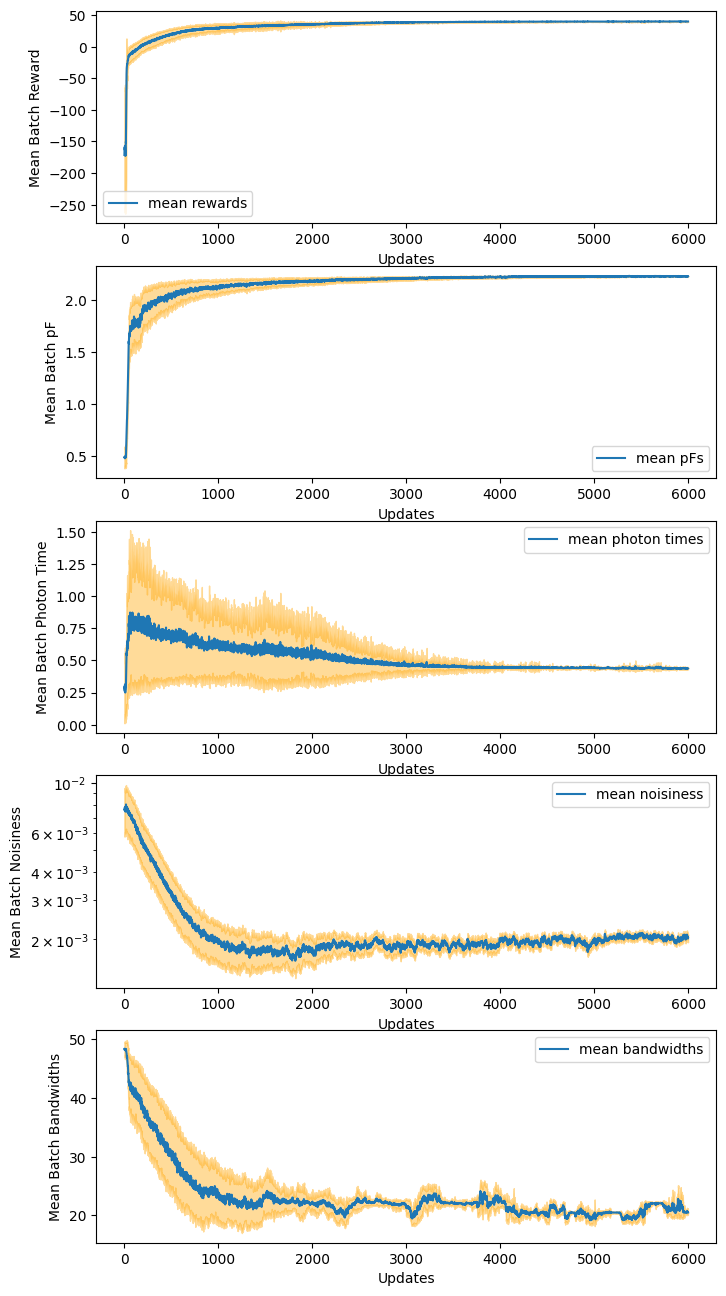

In [9]:
plot_learning(
    rewards=rewards,
    max_pFs=max_pFs,
    photon_times=photon_times,
    smoothnesses=smoothnesses,
    bandwidths=bandwidths,
)

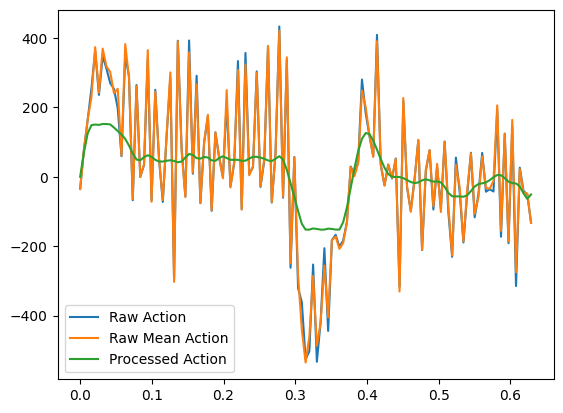

In [10]:
final_action = -actions[-1, 0]
mean_action = jnp.mean(-actions[-1], axis=0)
final_processed_action = env.prepare_action(final_action)

plt.plot(env.ts_action, final_action * env.a0, label='Raw Action')
plt.plot(env.ts_action, mean_action * env.a0, label='Raw Mean Action')
plt.plot(env.ts_action, final_processed_action, label='Processed Action')
plt.legend()
plt.show()

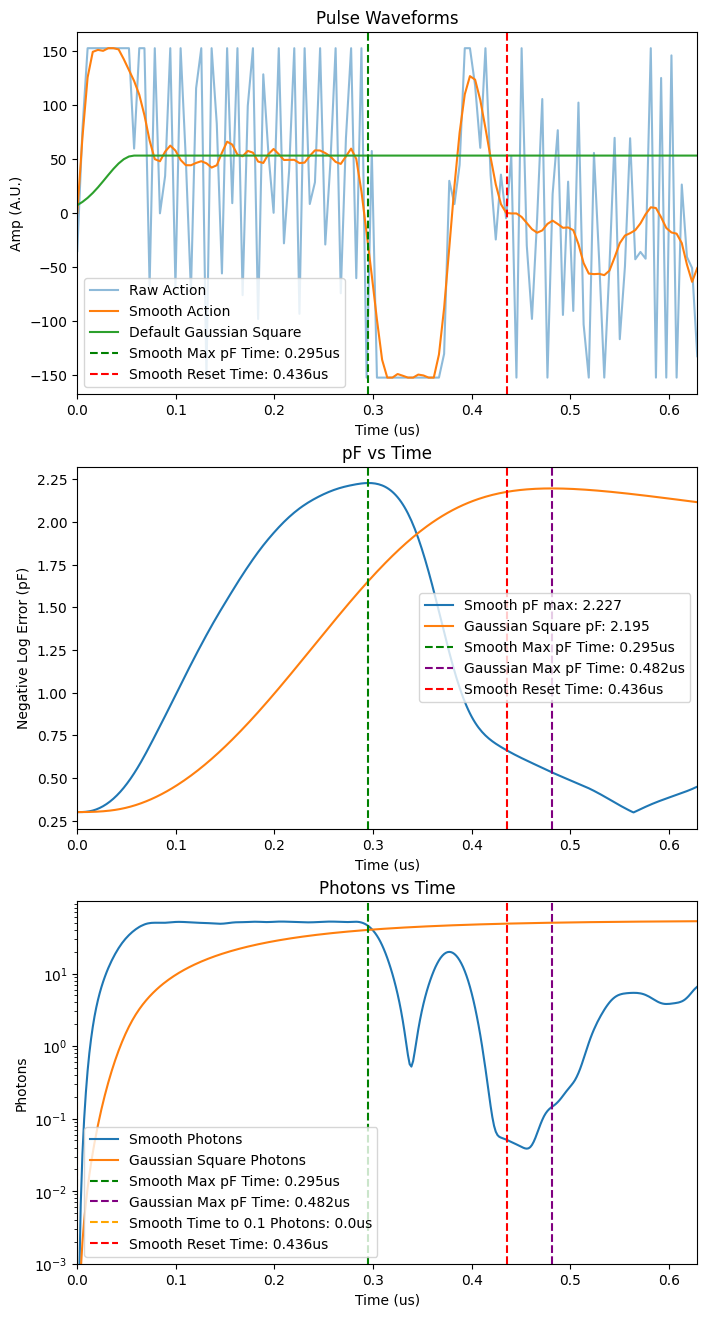

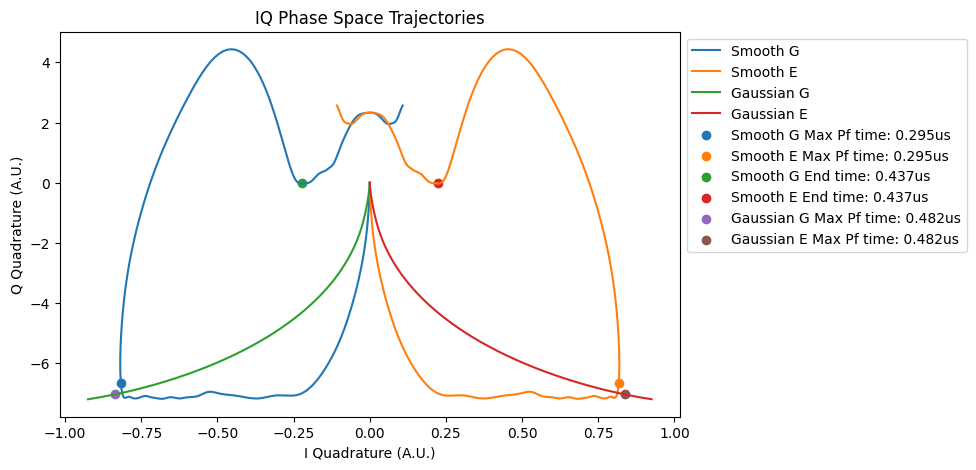

In [11]:
env.rollout_action(_rng, final_action, photon_log_scale=True)

In [14]:
pf_reward = env.pf_reward(max_pFs)
time_reward = env.time_reward(photon_times)
smoothness_reward = env.smoothness_reward(smoothnesses)
amp_reward = env.amp_reward(amps)

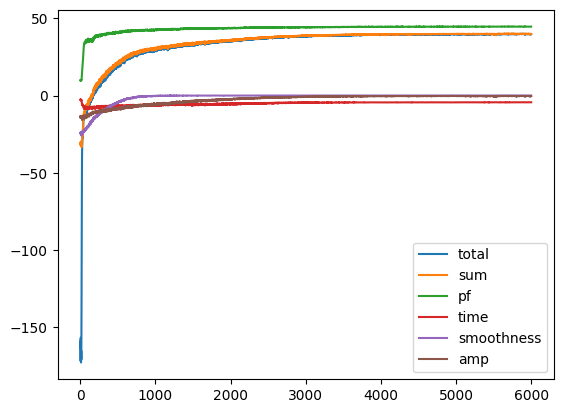

In [15]:
mean_pf_reward = jnp.mean(pf_reward, axis=-1)
mean_time_reward = jnp.mean(time_reward, axis=-1)
mean_smoothness_reward = jnp.mean(smoothness_reward, axis=-1)
mean_amp_reward = jnp.mean(amp_reward, axis=-1)
mean_sum_reward = mean_pf_reward + mean_time_reward + mean_smoothness_reward + mean_amp_reward
mean_reward = jnp.mean(rewards, axis=-1)

plt.plot(mean_reward, label='total')
plt.plot(mean_sum_reward, label='sum')
plt.plot(mean_pf_reward, label='pf')
plt.plot(mean_time_reward, label='time')
plt.plot(mean_smoothness_reward, label='smoothness')
plt.plot(mean_amp_reward, label='amp')
plt.legend()
plt.show()

## Kyoto Training

In [23]:
# Defining Kyoto Params and RL Params

tau_0 = 0.720
kappa = 10.07
chi = 0.92 * 2. * jnp.pi
kerr = 0.002
n0 = 25.5
res_amp_scaling = 1/0.51
actual_max_photons = n0 * (1. - 2. * jnp.cos(0.5 * chi * tau_0) * jnp.exp(-0.5 * kappa * tau_0) + jnp.exp(-0.5 * kappa * tau_0))
actual_max_photons = 25.5
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.1
snr_scale_factor = 0.6
gamma_I = 1/286
photon_gamma = 1/1200
init_fid = 1.

time_coeff = 10.0
snr_coeff = 20.0
smoothness_coeff = 10.0
smoothness_baseline_scale = 0.5
gauss_kernel_len = 15
gauss_kernel_std = 2.0
bandwidth = 50.0
freq_relative_cutoff = 0.1
bandwidth_coeff = 0.0
num_t1 = 6.0
photon_weight = 8.0
shot_noise_std = 0.0
standard_fid = 0.99

env_config = {"kappa": kappa,
    "chi": chi,
    "kerr": kerr,
    "time_coeff": time_coeff,
    "snr_coeff": snr_coeff,
    "smoothness_coeff": smoothness_coeff,
    "smoothness_baseline_scale": smoothness_baseline_scale,
    "gauss_kernel_len": gauss_kernel_len,
    "gauss_kernel_std": gauss_kernel_std,
    "bandwidth": bandwidth,
    "freq_relative_cutoff": freq_relative_cutoff,
    "bandwidth_coeff": bandwidth_coeff,
    "n0": n0,
    "tau_0": tau_0,
    "res_amp_scaling": res_amp_scaling,
    "nR": nR,
    "snr_scale_factor": snr_scale_factor,
    "gamma_I": gamma_I,
    "photon_gamma": photon_gamma,
    "num_t1": num_t1,
    "init_fid": init_fid,
    "photon_weight": photon_weight,
    "standard_fid": standard_fid,
    "shot_noise_std": shot_noise_std,
}

num_envs = 256
num_updates = 5000
kyoto_config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 128,
    "ENV_NAME": "single_langevin_env",
    "ENV_PARAMS": env_config,
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 25.5
Actual Max Photons: 25.5


In [24]:
kyoto_env = photon_env_dicts()[kyoto_config["ENV_NAME"]](**kyoto_config["ENV_PARAMS"])

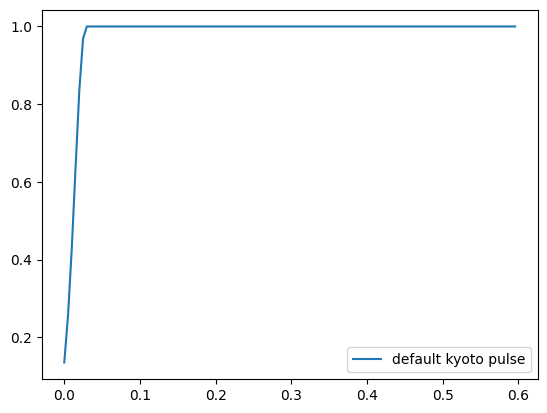

In [25]:
# Default Kyoto Action

ts = kyoto_env.ts_action

gauss_sigma = 0.0142
num_sigma = 2.
total_duration = tau_0

default_pulse = jnp.heaviside((total_duration - num_sigma * gauss_sigma) - ts, 1.) * jnp.heaviside(ts - num_sigma * gauss_sigma, 0.)
default_pulse += jnp.heaviside(num_sigma * gauss_sigma - ts, 1.) * jnp.exp(-(ts - num_sigma * gauss_sigma)**2 / (2 * gauss_sigma**2))
default_pulse += jnp.heaviside(ts - (total_duration - num_sigma * gauss_sigma), 1.) * jnp.exp(-(ts - (total_duration - num_sigma * gauss_sigma))**2 / (2 * gauss_sigma**2))

plt.plot(ts, default_pulse, label='default kyoto pulse')
plt.legend()
plt.show()

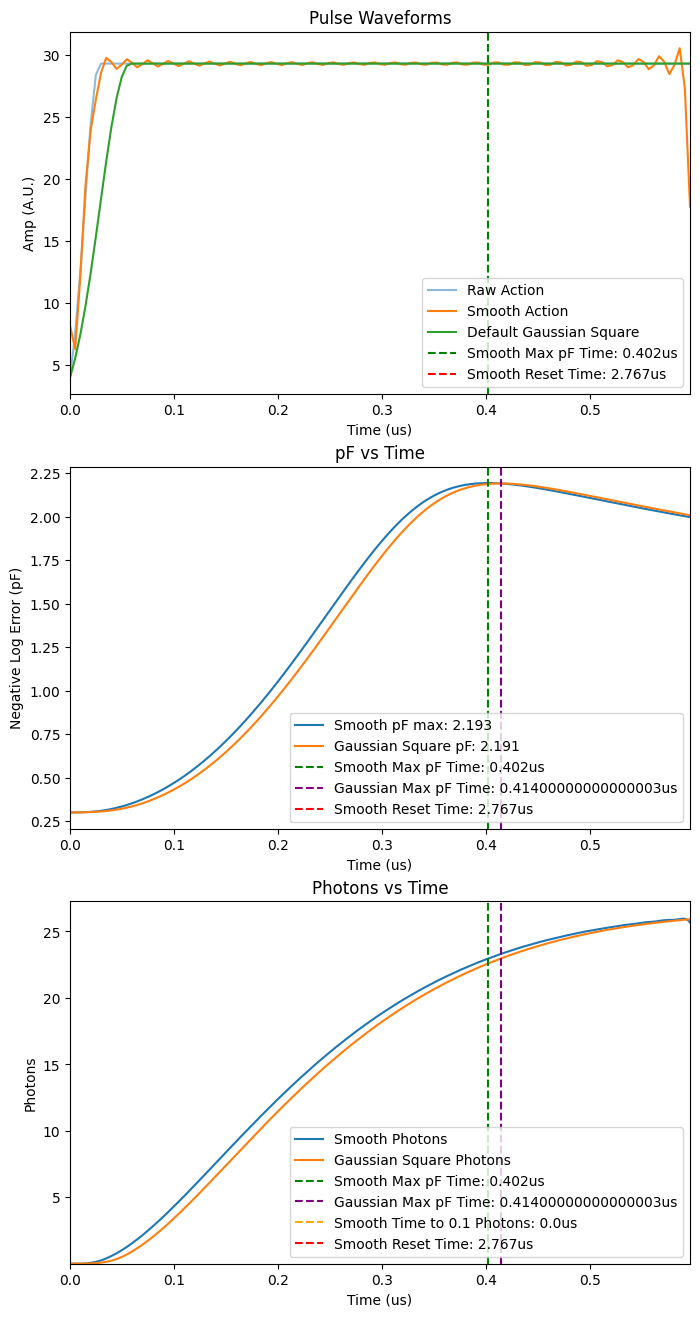

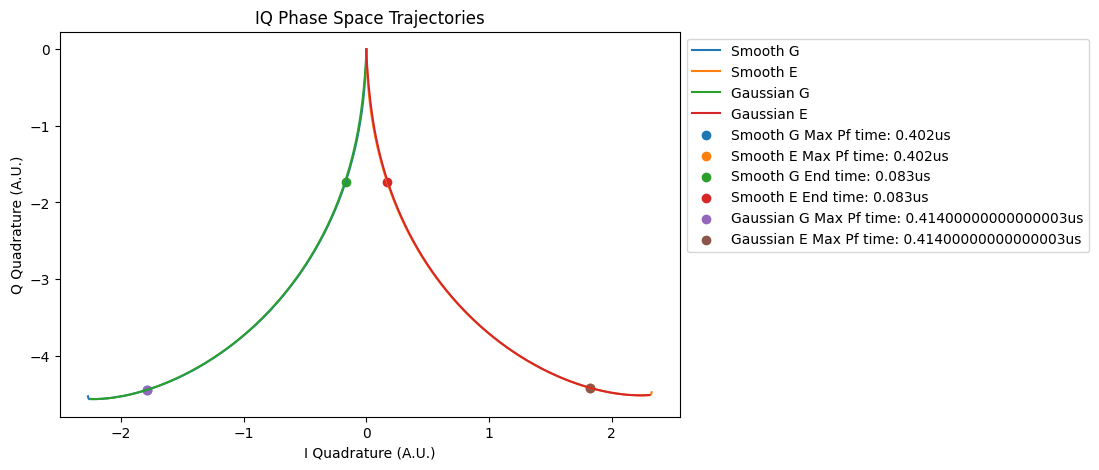

In [26]:
kyoto_env.rollout_action(_rng, default_pulse)

In [27]:
kyoto_train = jit(PPO_make_train(kyoto_config), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
kyoto_result = kyoto_train(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 5000 Updates
global update: 100
reward: -51.792
max pF: 2.11
max photon: 23.641000000000002
photon time: 1.2712
smoothness: 0.009125
bandwidth: 32.834
pulse reset val: 0.196
global update: 200
reward: -6.816
max pF: 2.141
max photon: 23.403000000000002
photon time: 0.9281
smoothness: 0.004817
bandwidth: 22.971
pulse reset val: 0.158
global update: 300
reward: 19.622
max pF: 2.174
max photon: 24.431
photon time: 0.8378
smoothness: 0.0024089999999999997
bandwidth: 16.638
pulse reset val: 0.081
global update: 400
reward: 27.767
max pF: 2.183
max photon: 24.628
photon time: 0.7899
smoothness: 0.001758
bandwidth: 15.104000000000001
pulse reset val: 0.047
global update: 500
reward: 32.088
max pF: 2.192
max photon: 25.093
photon time: 0.7559
smoothness: 0.001352
bandwidth: 14.993
pulse reset val: 0.038
global update: 600
reward: 34.286
max pF: 2.193
max photon: 25.022000000000002
photon time: 0.731
smoothness: 0.001207
bandwidth: 14.987
pulse reset val: 0.024
global update: 

In [28]:
# Extracting Results

k_metrics = kyoto_result["metrics"]

k_rewards = k_metrics["reward"]
k_max_pFs = k_metrics["max pF"]
k_max_photons = k_metrics["max photon"]
k_photon_times = k_metrics["photon time"]
k_smoothnesses = k_metrics["smoothness"]
k_bandwidths = k_metrics["bandwidth"]
k_actions = k_metrics["action"]
k_amps = k_metrics["pulse reset val"]

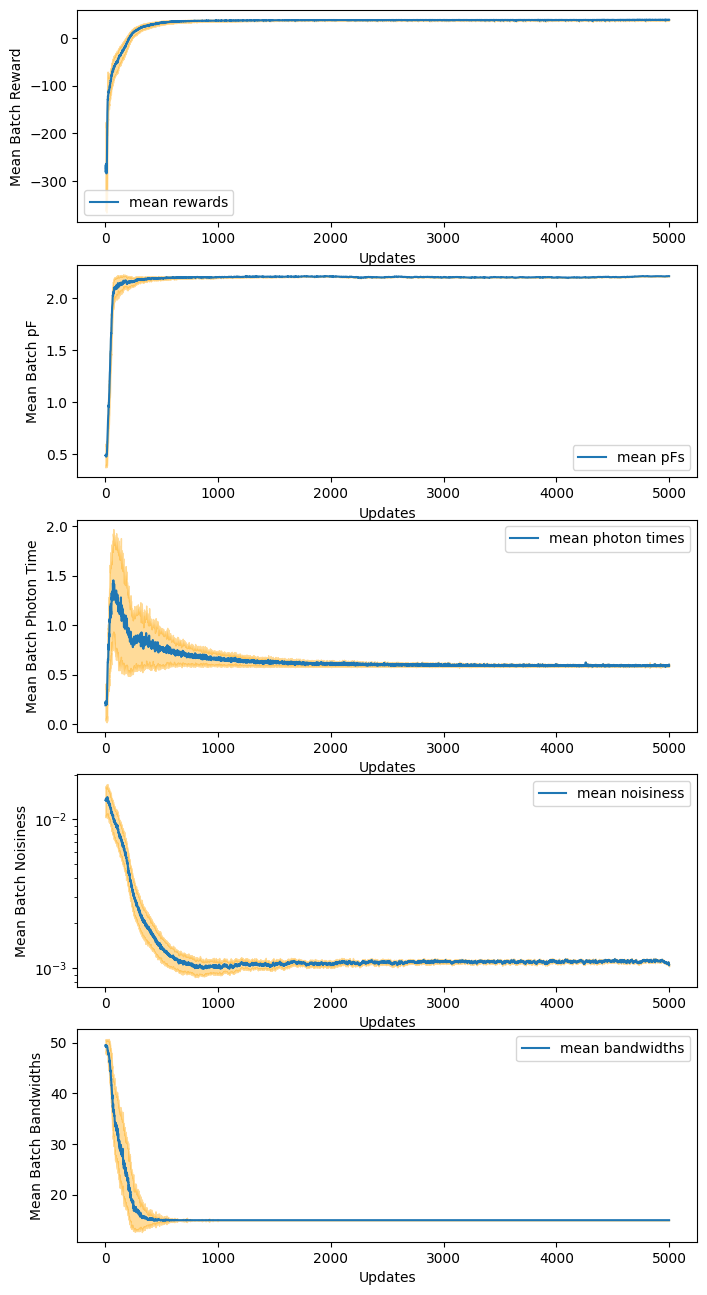

In [29]:
plot_learning(
    rewards=k_rewards,
    max_pFs=k_max_pFs,
    photon_times=k_photon_times,
    smoothnesses=k_smoothnesses,
    bandwidths=k_bandwidths,
)

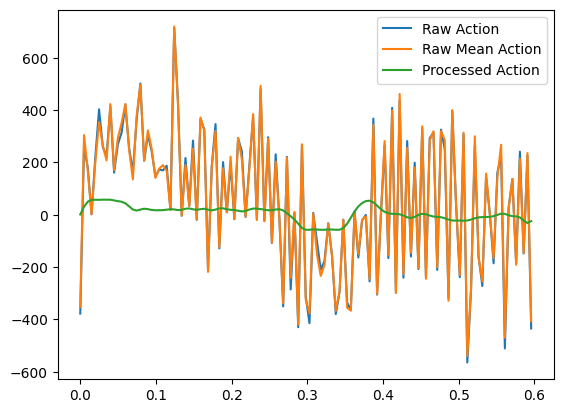

In [32]:
k_final_action = k_actions[-1, 0]
k_mean_action = jnp.mean(k_actions[-1], axis=0)
k_final_processed_action = kyoto_env.prepare_action(final_action)

plt.plot(kyoto_env.ts_action, k_final_action * kyoto_env.a0, label='Raw Action')
plt.plot(kyoto_env.ts_action, k_mean_action * kyoto_env.a0, label='Raw Mean Action')
plt.plot(kyoto_env.ts_action, k_final_processed_action, label='Processed Action')
plt.legend()
plt.show()

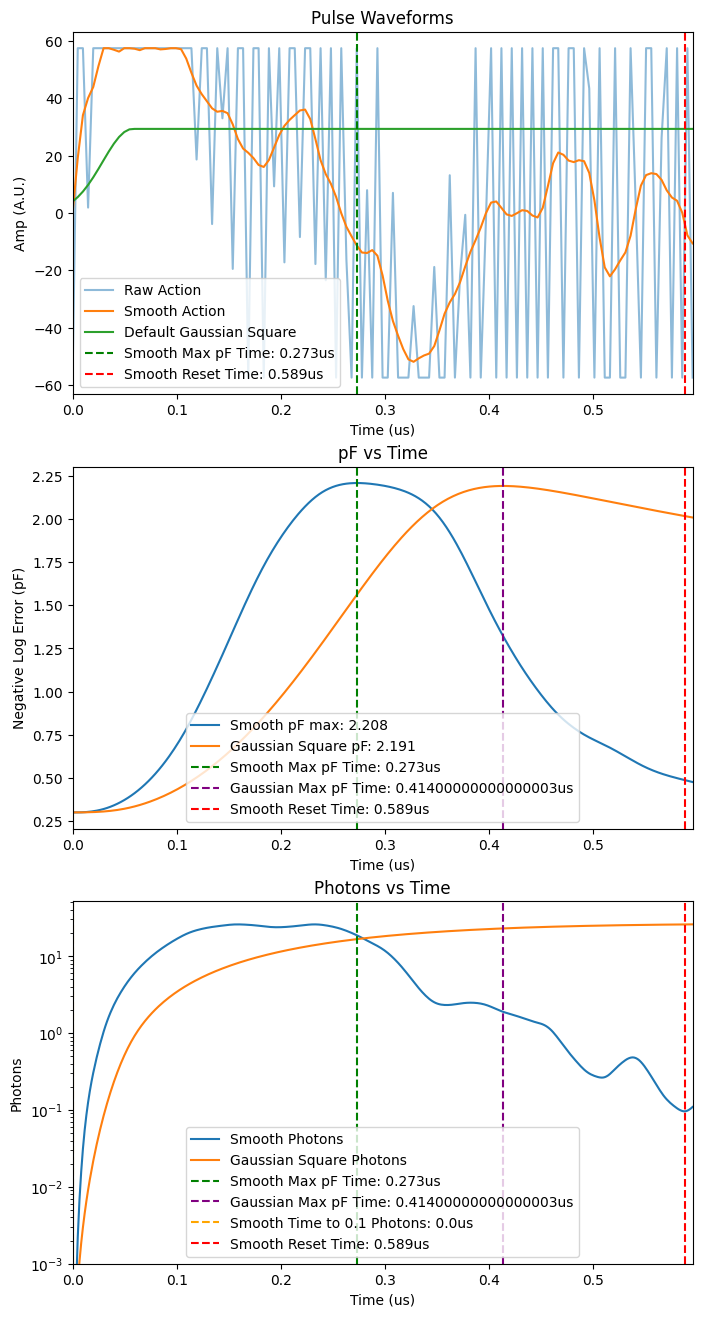

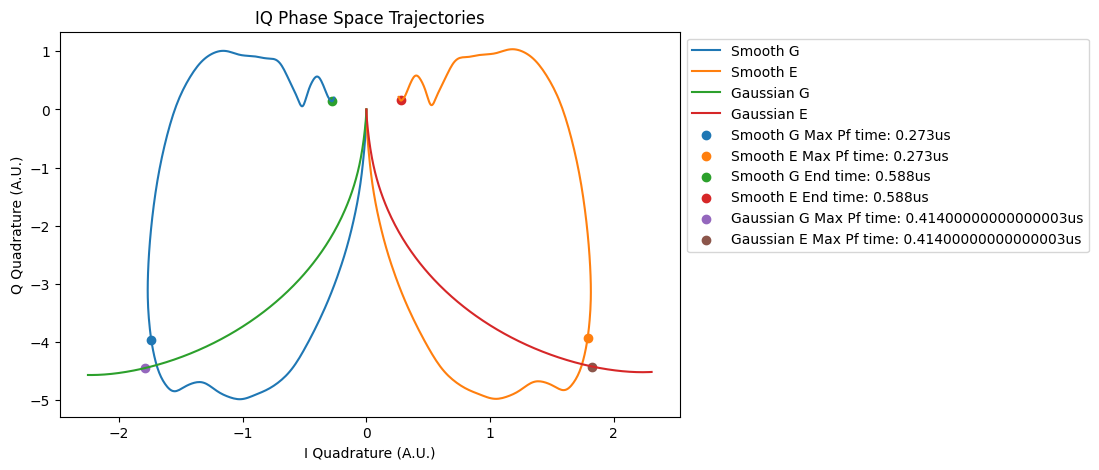

In [33]:
kyoto_env.rollout_action(_rng, k_final_action, photon_log_scale=True)

In [36]:
k_pf_reward = kyoto_env.pf_reward(k_max_pFs)
k_time_reward = kyoto_env.time_reward(k_photon_times)
k_smoothness_reward = kyoto_env.smoothness_reward(k_smoothnesses)
k_amp_reward = kyoto_env.amp_reward(k_amps)

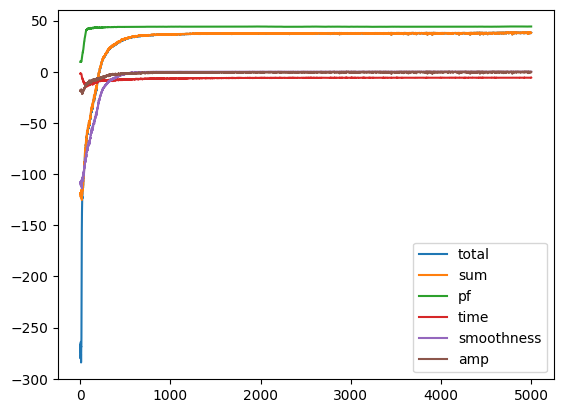

In [37]:
k_mean_pf_reward = jnp.mean(k_pf_reward, axis=-1)
k_mean_time_reward = jnp.mean(k_time_reward, axis=-1)
k_mean_smoothness_reward = jnp.mean(k_smoothness_reward, axis=-1)
k_mean_amp_reward = jnp.mean(k_amp_reward, axis=-1)
k_mean_sum_reward = k_mean_pf_reward + k_mean_time_reward + k_mean_smoothness_reward + k_mean_amp_reward
k_mean_reward = jnp.mean(k_rewards, axis=-1)

plt.plot(k_mean_reward, label='total')
plt.plot(k_mean_sum_reward, label='sum')
plt.plot(k_mean_pf_reward, label='pf')
plt.plot(k_mean_time_reward, label='time')
plt.plot(k_mean_smoothness_reward, label='smoothness')
plt.plot(k_mean_amp_reward, label='amp')
plt.legend()
plt.show()

In [40]:
# saving sherbrooke data
sherbrooke_reward_array = jnp.concatenate(
    (
        rewards.reshape(1, *rewards.shape),
        pf_reward.reshape(1, *pf_reward.shape),
        time_reward.reshape(1, *time_reward.shape),
        smoothness_reward.reshape(1, *smoothness_reward.shape),
        amp_reward.reshape(1, *amp_reward.shape),
    ),
    axis=0
)
np.save("fig 2 sherbrooke rewards", sherbrooke_reward_array)

In [41]:
# saving kyoto data
kyoto_reward_array = jnp.concatenate(
    (
        k_rewards.reshape(1, *k_rewards.shape),
        k_pf_reward.reshape(1, *k_pf_reward.shape),
        k_time_reward.reshape(1, *k_time_reward.shape),
        k_smoothness_reward.reshape(1, *k_smoothness_reward.shape),
        k_amp_reward.reshape(1, *k_amp_reward.shape),
    ),
    axis=0
)
np.save("fig 2 kyoto rewards", kyoto_reward_array)